## Loading and normalizing CIFAR10

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root = './data',
                                        train = True,
                                        download = True,
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4,
                                          shuffle = True,
                                          num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data',
                                       train= False,
                                       download = True,
                                       transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False,
                                         num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 26758911.53it/s]                               


Files already downloaded and verified


###Seeing some of the training images for fun.

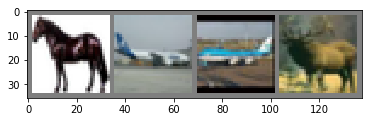

horse plane plane  deer


In [3]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image

def imshow(img):
  img = img / 2 + 0.5 ## unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
  
## get some random training images

dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images

imshow(torchvision.utils.make_grid(images))

## print labels

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Defining a CNN

### This will take 3-channel images

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

## Defining a Loss function and optimizer

In [0]:
## Using a Classification Cross-Entropy loss and SGD with momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001,
                      momentum = 0.9)

## Training the network

In [6]:
for epoch in range(2):  ## loop over the dataset multiple times
  
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    ## get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    
    ## zero the parameter gradients
    optimizer.zero_grad()
    
    ## forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    ## print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:  ## print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
      
print('Finished Training')

[1,  2000] loss: 2.246
[1,  4000] loss: 1.882
[1,  6000] loss: 1.664
[1,  8000] loss: 1.577
[1, 10000] loss: 1.506
[1, 12000] loss: 1.442
[2,  2000] loss: 1.382
[2,  4000] loss: 1.366
[2,  6000] loss: 1.314
[2,  8000] loss: 1.300
[2, 10000] loss: 1.292
[2, 12000] loss: 1.282
Finished Training


## Testing the network on the test data

### 1) We'll predict the class label that the NN outputs, and check it against the ground-truth. If the prediction is correct, we'll add the sample to the list of correct predictions.

### Let's display an image from the test set

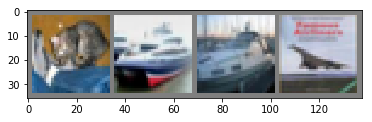

Ground Truth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

## print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### And what does the NN think these examples above are?

In [0]:
outputs = net(images)

### 2) The outputs are energies for the 10 classes. 

### The higher the energy for a class, the more the network thinks that the image is of the particular class. Let's get the index of the highest energy:

In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                               for j in range(4)))

Predicted:    cat   car   car plane


### 3) Let's look at how the network performs on the whole dataset:

In [10]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total
))

Accuracy of the network on the 10000 test images: 56 %


### 4) Which classes performed well? Which didn't?

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
      
for i in range(10):
  print('Accuracy of %5s: %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]
  ))

Accuracy of plane: 58 %
Accuracy of   car: 85 %
Accuracy of  bird: 44 %
Accuracy of   cat: 37 %
Accuracy of  deer: 38 %
Accuracy of   dog: 67 %
Accuracy of  frog: 55 %
Accuracy of horse: 61 %
Accuracy of  ship: 59 %
Accuracy of truck: 53 %


## Training on GPU

### Just as we transfer a Tensor onto the GPU, we transfer the neural net onto the GPU

### Let's define our device as the first visible cuda device if we have CUDA available:

In [12]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
## These methods will recursively go over all modules and convert their
## parameters and buffers to CUDA tensors

net.to(device)

## We will have to send the inputs and targets at every step to the GPU too:

inputs, labels = data[0].to(device), data[1].to(device)